In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !cp drive/MyDrive/kaggle/projectPhase2_dataset.zip .
# !unzip -q projectPhase2_dataset.zip
# !rm projectPhase2_dataset.zip

In [3]:
!pip install eli5

In [4]:
!pip install contractions

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.utils import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from wordcloud import WordCloud, STOPWORDS
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, coo_matrix
from sklearn.metrics import classification_report, accuracy_score
import eli5
from sklearn.ensemble import AdaBoostClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
pd.set_option('display.max_colwidth', None)

#***EDA and feature engineering***

First we read the data and show a part of it to get a general idea about the columns and the data in them.

In [8]:
df = pd.read_csv('sarcasm_train_set.csv')

In [9]:
df.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."
1,1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.
2,2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,5,0,"I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?


below we can see columns and their data types.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808998 entries, 0 to 808997
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      808998 non-null  int64 
 1   label           808998 non-null  int64 
 2   comment         808960 non-null  object
 3   author          808998 non-null  object
 4   subreddit       808998 non-null  object
 5   score           808998 non-null  int64 
 6   ups             808998 non-null  int64 
 7   downs           808998 non-null  int64 
 8   date            808998 non-null  object
 9   created_utc     808998 non-null  object
 10  parent_comment  808998 non-null  object
dtypes: int64(5), object(6)
memory usage: 67.9+ MB


Now we want to study the columns one by one and remove or replace them with other columns. 

Our first observation is that `date` is subset of `created_utc`. to make sure, we ran the code below. if threre is a row where `date` is not subset of `created_utc` a "noooo" will be printed.

In [11]:
# for indx in df.index:
#     row = df.loc[indx]
#     if row['date'].split('-')[1] != row['created_utc'].split('-')[1]:
#         print('noooo', indx)

after running the code, we see no "noooo"s, so our observation was correct and we will remove the `date` column.

In [12]:
df = df.drop(columns = ['date'])

The `Unnamed: 0` column seems to have no special information apart from the indexes. so we will remove that:

In [13]:
df = df.drop(columns = ['Unnamed: 0'])

let's resolve NaNs. first, we want to compare the number of NaNs in each column. this comparison can easily be done by the informative bar chart below

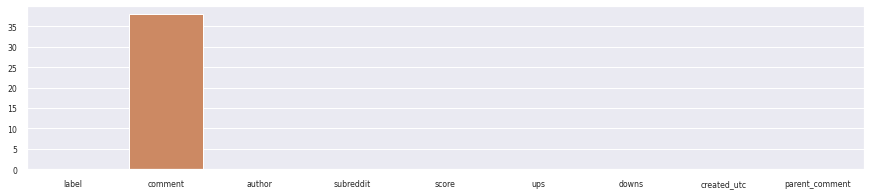

In [14]:
plt.figure(figsize=(15,3))
sns.set(font_scale=.7)
sns.barplot(y = df.isna().sum(), x = df.columns)
plt.show()

as we see, the only column with NaNs is `comment`. this is great, because it's so easy to resolve. `comment` being NaN means that row doesn't have the most important feature to recognize it's sarcasm, thus we simply remove all rows that have NaN `comment`.

In [15]:
df = df[df.comment.notna()]
df.shape

(808960, 9)

`created_utc` column has so much information in it, but it's not numerical and usable. the first step to make this information usable is to split it to different columns named `year`, `month`, `day_name`, `day_time`. the only one that needs explanation is `day_time`: it's derived by dividing day hours into `midnight`, `morining`, `afternoon` and `night`. after extracting all these features from `created_utc` we can safely remove it.

In [16]:
#Transform string to date
df['created_utc'] = pd.to_datetime(df['created_utc'], format="%Y-%m-%d")

df['year'] = df['created_utc'].dt.year
df['month'] = df['created_utc'].dt.month
df['day_name'] = df['created_utc'].dt.day_name()
df['day_time'] = pd.cut(df['created_utc'].dt.hour, bins=[0, 6, 12,18,24], labels=["midnight", "mornining", "afternoon", "night"], include_lowest=True, ordered=False)

df = df.drop(columns=['created_utc'])
df.head()

,label,comment,author,subreddit,score,ups,downs,parent_comment,year,month,day_name,day_time
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",2016,10,Sunday,night
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,2016,11,Tuesday,midnight
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,3,0,They're favored to win.,2016,9,Thursday,night
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,-1,-1,deadass don't kill my buzz,2016,10,Tuesday,night
4,0,"I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)",only7inches,AskReddit,0,0,0,do you find ariana grande sexy ?,2016,9,Friday,mornining


our experience from reddit shows that one can't see the specific numbers of upvote and downvote and only their sum is shown. and here,
`downs` column seems wired, let's see what values it can take.

In [17]:
print(f"downs column all possible values: {list(df.downs.unique())}")

downs column all possible values: [-1, 0]


so that's not a useful feature at all. we'll remove it. but let's check `ups` it seems to be equal to `score` where it's not -1. we check this by code below:

In [18]:
print(f"how much of ups column data is as same as score column data: {((df.ups == -1) | (df.ups == df.score)).sum()/len(df) * 100}%")

how much of ups column data is as same as score column data: 100.0%


so `ups` is redundant too.

In [19]:
df = df.drop(columns=['ups', 'downs'])
df.head()

,label,comment,author,subreddit,score,parent_comment,year,month,day_name,day_time
0,0,NC and NH.,Trumpbart,politics,2,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",2016,10,Sunday,night
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,2016,11,Tuesday,midnight
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,They're favored to win.,2016,9,Thursday,night
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,deadass don't kill my buzz,2016,10,Tuesday,night
4,0,"I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)",only7inches,AskReddit,0,do you find ariana grande sexy ?,2016,9,Friday,mornining


let's check if data is imbalance.

In [20]:
df['label'].value_counts()

1    404735
0    404225
Name: label, dtype: int64

data is nearly balanced and we won't have to worry about learning bias and class prior probabilities.

<hr/>

we hypothesize that comment length is a useful feature for recognizing sarcastic comments. we test this hypothesis with the plot below.

first we grouped rows based on their comments length into several proper ranges for visualization. two values are shown for each range in the plots below: `sarcasm_rate - .5` and `comment_count`.

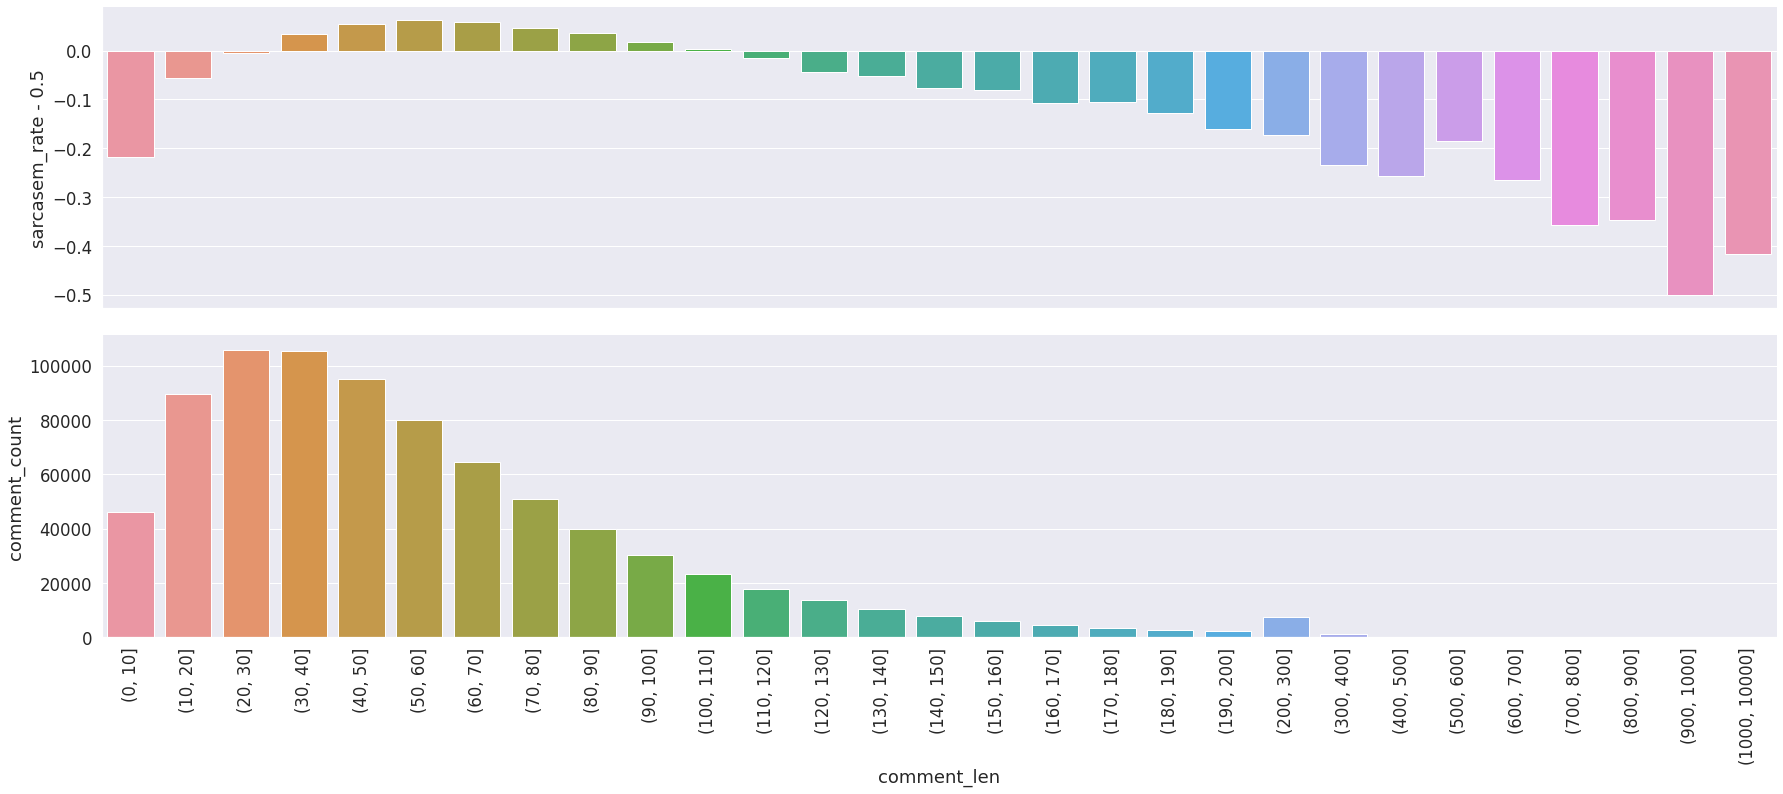

In [21]:
sns.set(font_scale=1.5)
max_len = df.comment.str.len().max()
len_check_df = df[["comment", "label"]].copy()
len_check_df.rename(columns={"comment": "comment_len", "label": "sarcasm"}, inplace=True)
len_check_df["normal"] = (len_check_df.sarcasm + 1) % 2
len_check_df['comment_count'] = len_check_df.sarcasm + len_check_df.normal
aranges = []
aranges.append(np.arange(0, 200, 10))
aranges.append(np.arange(200, 1000, 100))
aranges.append(np.arange(1000, max_len+1, max_len-1000))
len_check_df = len_check_df.groupby(pd.cut(len_check_df["comment_len"].str.len(), np.concatenate(aranges))).sum()
len_check_df.reset_index(inplace=True)
len_check_df['sarcasem_rate - 0.5'] = len_check_df.sarcasm / (len_check_df.sarcasm + len_check_df.normal) - 0.5
g = sns.PairGrid(len_check_df, y_vars=["sarcasem_rate - 0.5", "comment_count"], x_vars="comment_len", height=5, aspect=5)
g.map(sns.barplot);
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

as we see, too short or long comments are much less sarcastic. so we add this feature to our data:

<!-- #***Feature Engineering*** -->

In [22]:
df['comment_len'] = df.comment.str.len()
df.head()

,label,comment,author,subreddit,score,parent_comment,year,month,day_name,day_time,comment_len
0,0,NC and NH.,Trumpbart,politics,2,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",2016,10,Sunday,night,10
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,2016,11,Tuesday,midnight,74
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,They're favored to win.,2016,9,Thursday,night,121
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,deadass don't kill my buzz,2016,10,Tuesday,night,60
4,0,"I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)",only7inches,AskReddit,0,do you find ariana grande sexy ?,2016,9,Friday,mornining,112


TF-IDF is popular embedding method. it's efficiency for classification relies on the classes being different in their most frequent words. the difference of frequent words can be beautifully visualized by word clouds as seen below:

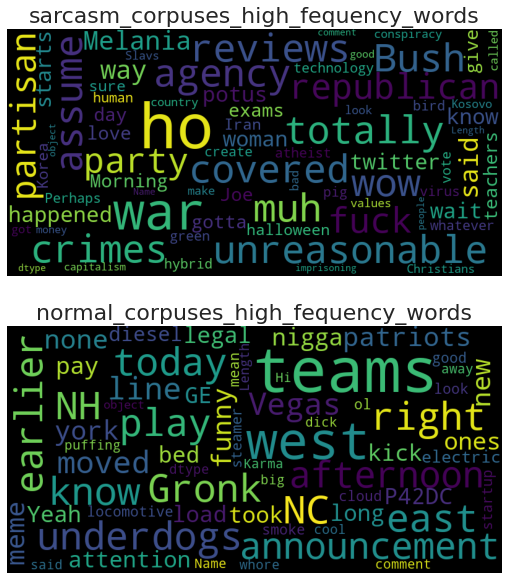

In [23]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

fig, axs = plt.subplots(2, figsize=(20,10))

axs[0].imshow(wordcloud.generate(str(df.loc[df['label'] == 1, 'comment'])))
axs[1].imshow(wordcloud.generate(str(df.loc[df['label'] == 0, 'comment'])))
axs[0].set_title("sarcasm_corpuses_high_fequency_words", fontsize=22)
axs[1].set_title("normal_corpuses_high_fequency_words", fontsize=22)
axs[0].axis('off')
axs[1].axis('off');

here we test if we can consider `subreddit` as a good feature.

we plotted three plots each of which visualize one aspect of `subreddit` column.

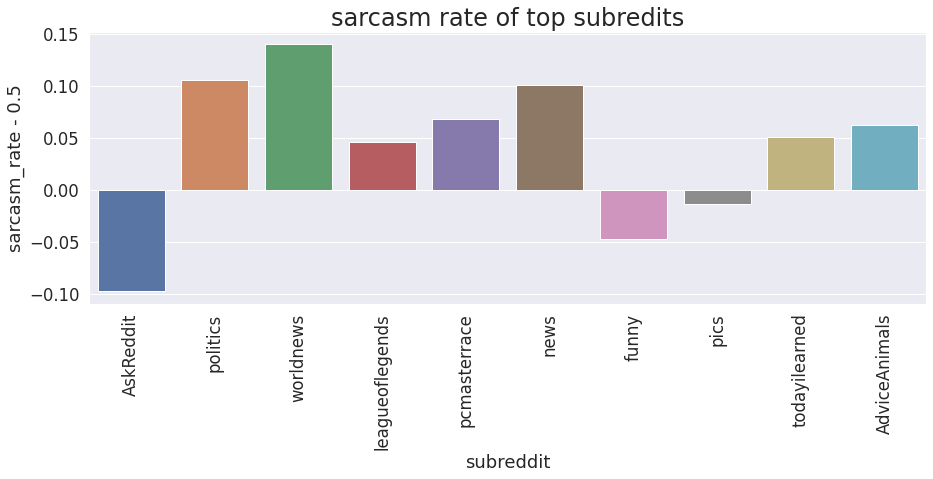

In [24]:
subreddit_df = df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum]).reset_index()
subreddit_df['sarcasm_rate - 0.5'] = subreddit_df['mean'] - 0.5

sns.set(font_scale=1.5)
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=subreddit_df.sort_values(by='sum', ascending=False).head(10) , x='subreddit', y='sarcasm_rate - 0.5')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.set(font_scale=2)
ax.set_title("sarcasm rate of top subredits");

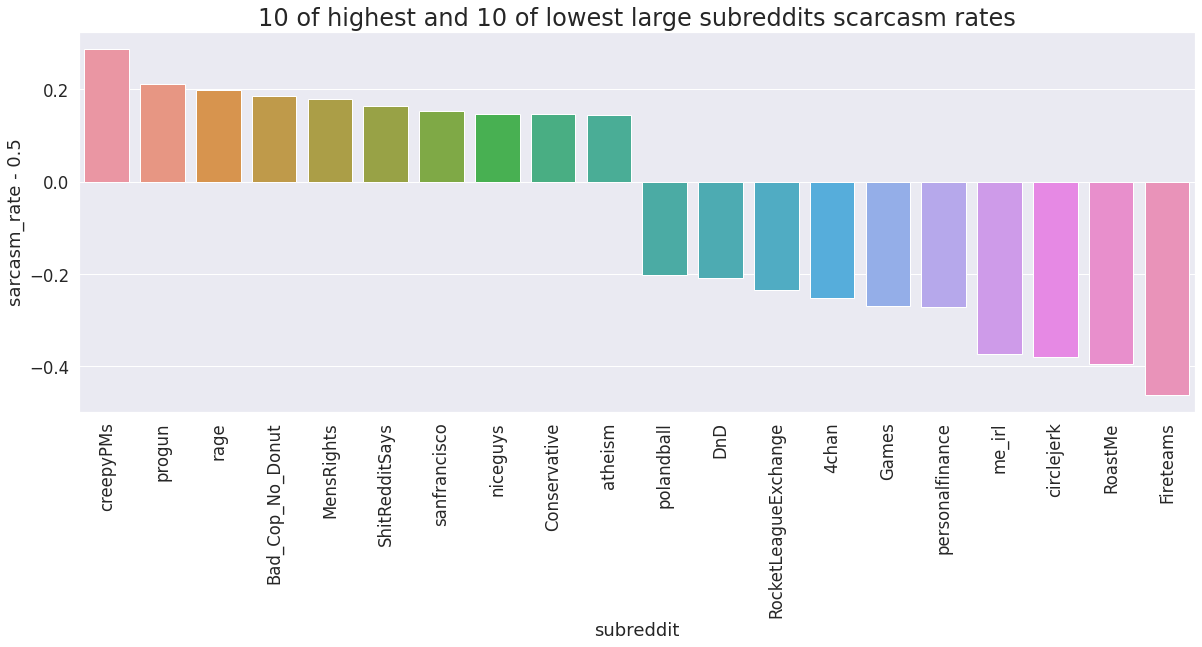

In [25]:
sorted_subreddit_df = subreddit_df[subreddit_df['size'] > 300].sort_values(by='mean', ascending=False).reset_index()
sorted_subreddit_df['sarcasm_rate - 0.5'] = sorted_subreddit_df['mean'] - 0.5

sns.set(font_scale=1.5)
plt.figure(figsize=(20, 7))
ax = sns.barplot(data=pd.concat([sorted_subreddit_df.head(10), sorted_subreddit_df.tail(10)]), x='subreddit', y='sarcasm_rate - 0.5')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.set(font_scale=2)
ax.set_title("10 of highest and 10 of lowest large subreddits scarcasm rates");

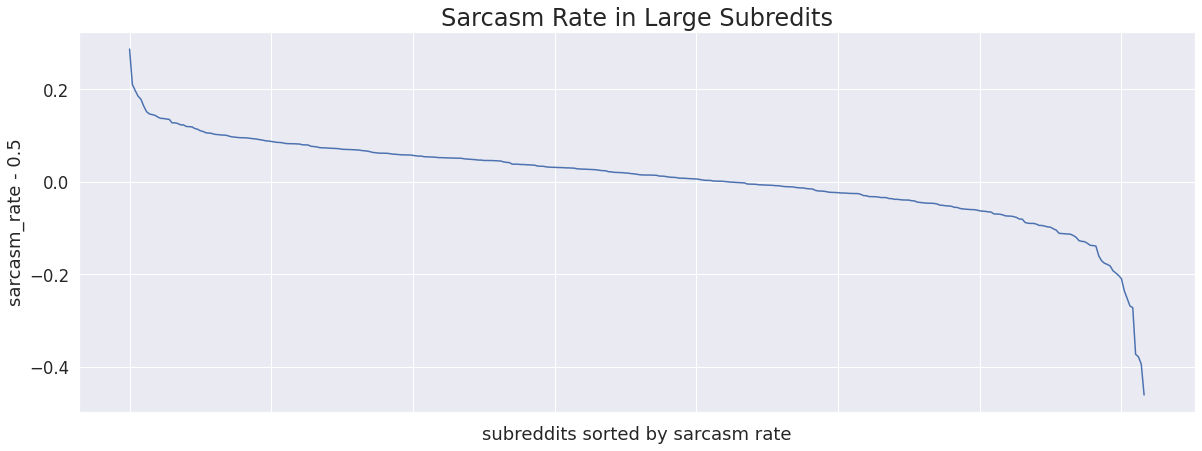

In [26]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 7))
ax = sns.lineplot(x=sorted_subreddit_df.index, y=sorted_subreddit_df['sarcasm_rate - 0.5'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xlabel("subreddits sorted by sarcasm rate")
sns.set(font_scale=2)
ax.set_title("Sarcasm Rate in Large Subredits");

so `subreddit` has enough information to be considered as feature. but the problem is that it's not numerical, so we substitute each subreddit with it's mean sarcasm rate, which is a good numerical replacement.

In [27]:
df['subreddit'] = df.groupby('subreddit')['label'].transform('mean') - 0.5

`author` is very similar to `subreddit`(in fact, each reddit user's posts are in a separate subreddit like thread). so we do the same visualization to see if it's worthy of being a feature!

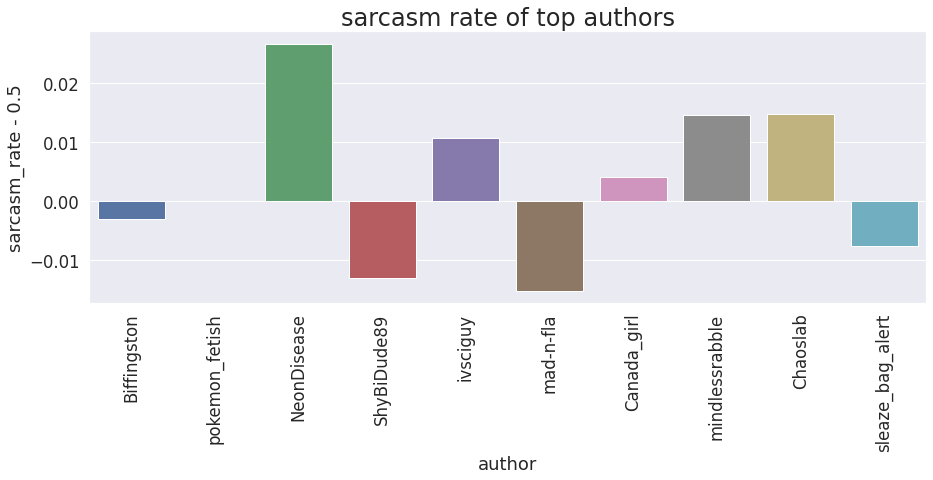

In [28]:
authors_df = df.groupby('author')['label'].agg([np.size, np.mean, np.sum]).reset_index()
authors_df['sarcasm_rate - 0.5'] = authors_df['mean'] - 0.5


sns.set(font_scale=1.5)
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=authors_df.sort_values(by='size', ascending=False).head(10) , x='author', y='sarcasm_rate - 0.5')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.set(font_scale=2)
ax.set_title("sarcasm rate of top authors");

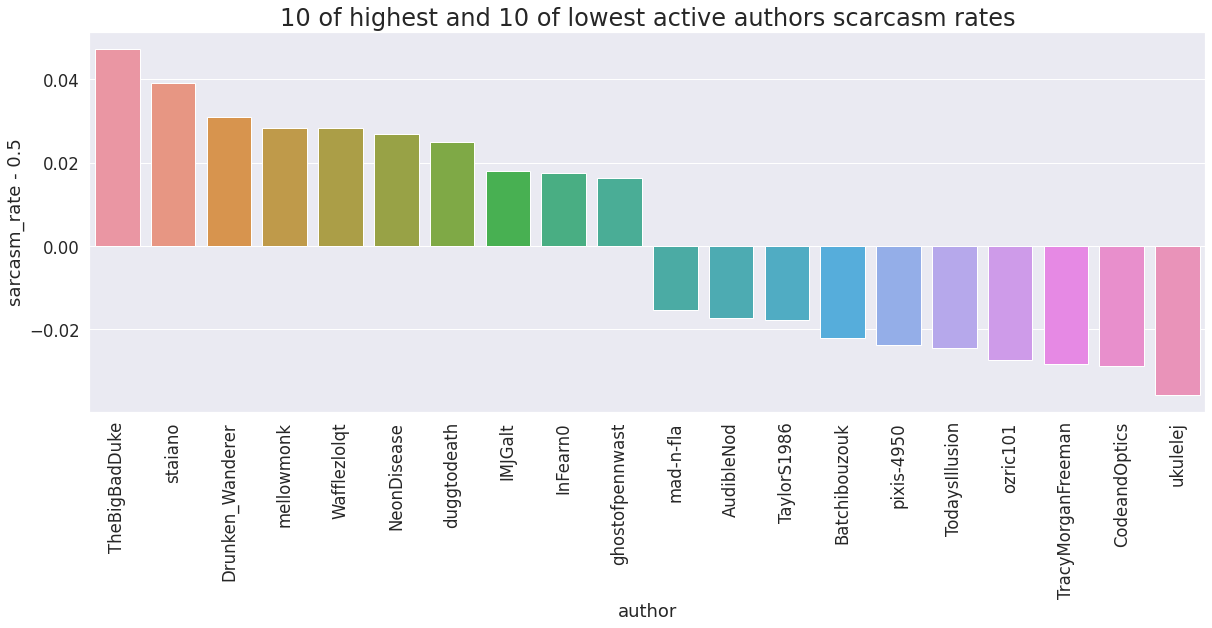

In [29]:
sorted_authors_df = authors_df[authors_df['size'] > 100].sort_values(by='mean', ascending=False).reset_index()

sns.set(font_scale=1.5)
plt.figure(figsize=(20, 7))
ax = sns.barplot(data=pd.concat([sorted_authors_df.head(10), sorted_authors_df.tail(10)]), x='author', y='sarcasm_rate - 0.5')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.set(font_scale=2)
ax.set_title("10 of highest and 10 of lowest active authors scarcasm rates");

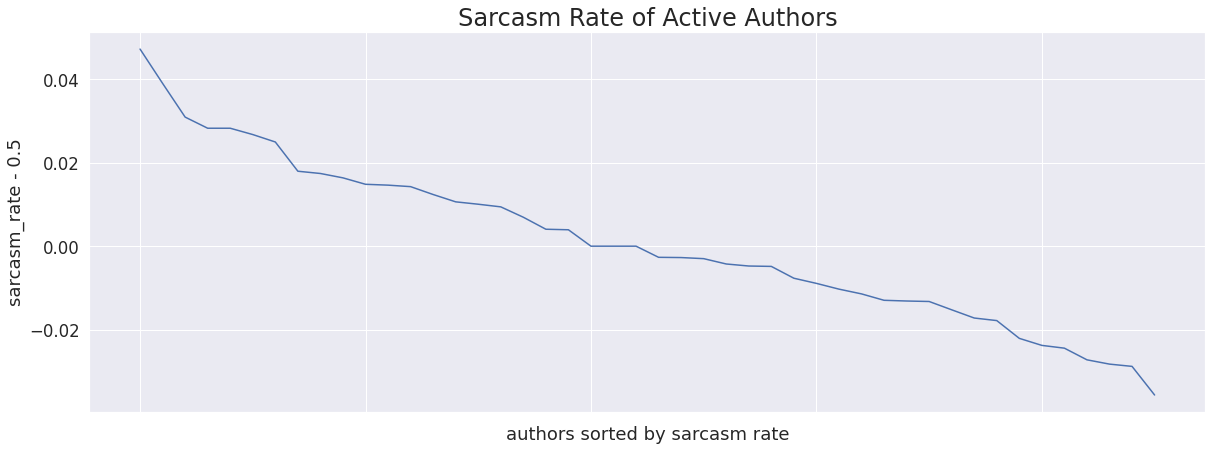

In [30]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 7))
ax = sns.lineplot(x=sorted_authors_df.index, y=sorted_authors_df['sarcasm_rate - 0.5'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xlabel("authors sorted by sarcasm rate")
sns.set(font_scale=2)
ax.set_title("Sarcasm Rate of Active Authors");

as we see, `author` is not a good feature to keep.

In [31]:
df.drop('author', axis=1, inplace=True);
df.head()

,label,comment,subreddit,score,parent_comment,year,month,day_name,day_time,comment_len
0,0,NC and NH.,0.105521,2,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",2016,10,Sunday,night,10
1,0,You do know west teams play against west teams more than east teams right?,0.026279,-4,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,2016,11,Tuesday,midnight,74
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",0.004146,3,They're favored to win.,2016,9,Thursday,night,121
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",-0.120219,-8,deadass don't kill my buzz,2016,10,Tuesday,night,60
4,0,"I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)",-0.097693,0,do you find ariana grande sexy ?,2016,9,Friday,mornining,112


let's study about `score`. to visualize the correlation between score and sarcasm we grouped comments with similar scores and evaluated the sarcasm rate of each group. we then sort these intervals and draw two plots: one shows the `sarcasm_rate -.5` and the other one shows `log10(comment_count)` in each group.

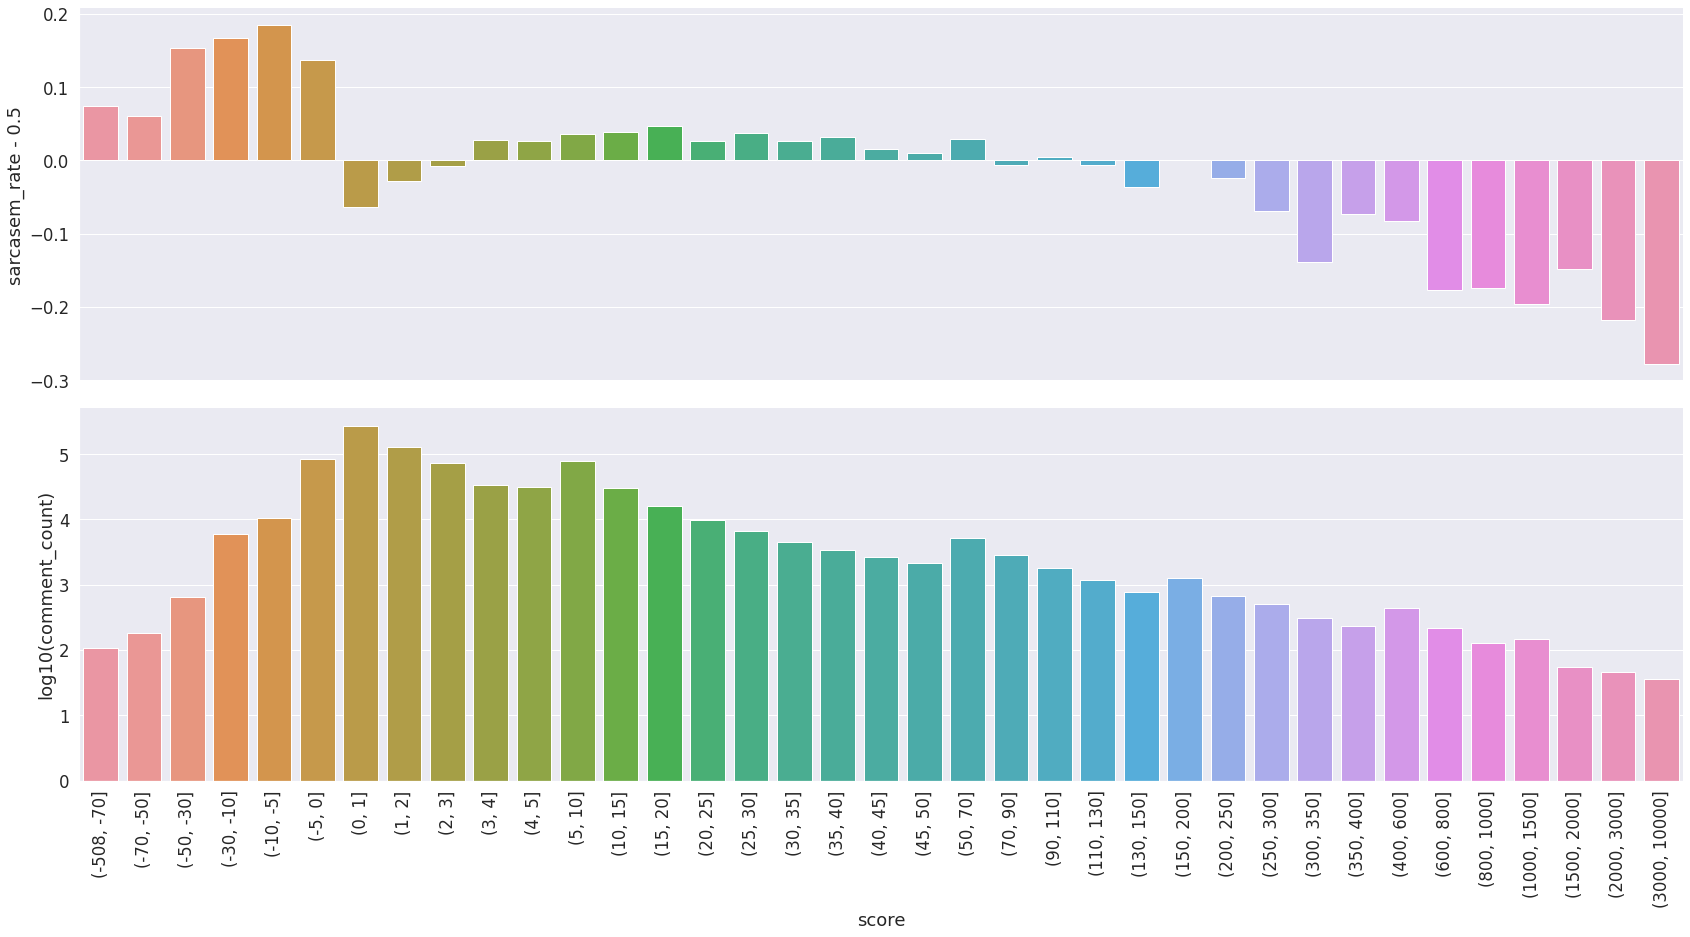

In [32]:
sns.set(font_scale=1.5)
max_score, min_score = df.score.max(), df.score.min()
score_check_df = df[["score", "label"]].copy()
score_check_df.rename(columns={"score": "score", "label": "sarcasm"}, inplace=True)
score_check_df["normal"] = (score_check_df.sarcasm + 1) % 2
score_check_df['comment_count'] = score_check_df.sarcasm + score_check_df.normal
aranges = []
aranges.append(np.arange(min_score-1, -70, -70-min_score+1))
aranges.append(np.arange(-70, -10, 20))
aranges.append(np.arange(-10, 0, 5))
aranges.append(np.arange(0, 5, 1))
aranges.append(np.arange(5, 50, 5))
aranges.append(np.arange(50, 150, 20))
aranges.append(np.arange(150, 400, 50))
aranges.append(np.arange(400, 1000, 200))
aranges.append(np.arange(1000, 2000, 500))
aranges.append(np.arange(2000, 3000, 1000))
aranges.append(np.arange(3000, max_len+1, max_len-3000))
score_check_df = score_check_df.groupby(pd.cut(score_check_df["score"], np.concatenate(aranges))).sum()
score_check_df.drop('score', axis=1, inplace=True)
score_check_df['log10(comment_count)'] = np.log10(score_check_df.comment_count)
score_check_df.reset_index(inplace=True)
score_check_df['sarcasem_rate - 0.5'] = score_check_df.sarcasm / (score_check_df.sarcasm + score_check_df.normal) - 0.5
g = sns.PairGrid(score_check_df, y_vars=["sarcasem_rate - 0.5", "log10(comment_count)"], x_vars="score", height=6, aspect=4)
g.map(sns.barplot);
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

very low and very high scores show high divergence between the number of sarcastic and non-sarcastic comments.
so at the end we keep `score` as is, as a feature.

<hr/>

does daytime really affect the sarcasm of people? let's see. we compare the number of sarcastic comment in each part of day in the plot below.

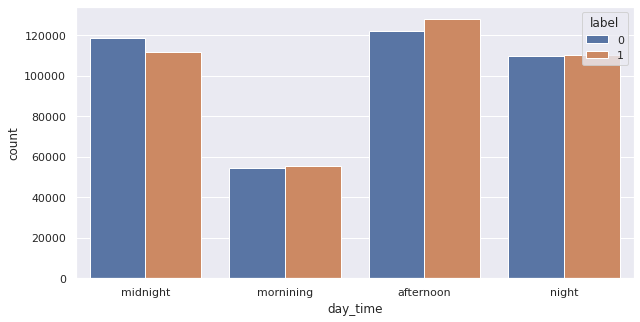

In [33]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1)
sns.countplot(x='day_time', hue='label', data=df);

as we see, midnight and afternoon have an effect on sarcasm rate. so we add them as boolean features and discard `day_time`.

In [34]:
df['midnight'] = df.day_time == 'midnight'
df['afternoon'] = df.day_time == 'afternoon'
df.drop('day_time', axis=1, inplace=True)

here we want to see if we can extract some usable features from `day_name`.

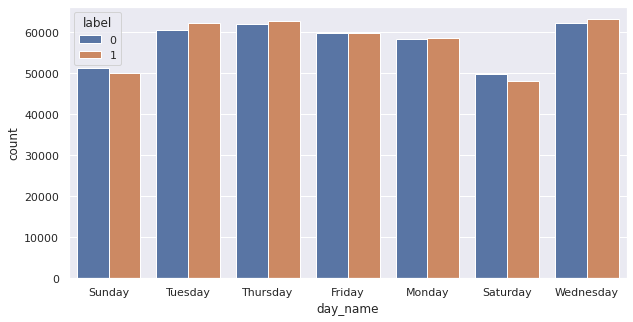

In [35]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1)
sns.countplot(x='day_name', hue='label', data=df);

the only days with an effect seem to be weekend days(sunday and saturday) and tuesday. we add these as boolean features.

In [36]:
df['Weekend'] = (df.day_name == "Sunday") | (df.day_name == "Saturday")
df['Tuesday'] = df.day_name == "Tuesday"
df.drop('day_name', axis=1, inplace=True)

this time we want measure `month` effect on sarcasm rate.

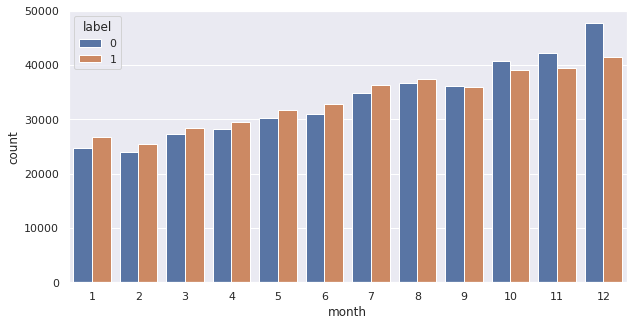

In [37]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1)
sns.countplot(x='month', hue='label', data=df);

as we see the months at the end of the year have less sarcasm and the month at the beginning of the year have more sarcasm. we add these as boolean features.

In [38]:
df['end_of_year'] = df.month >= 10
df['beginning_of_year'] = df.month <= 7
df.drop('month', axis=1, inplace=True)

maybe years have had an effect of how sarcastic people are. let's visualize sarcasm rate for years.

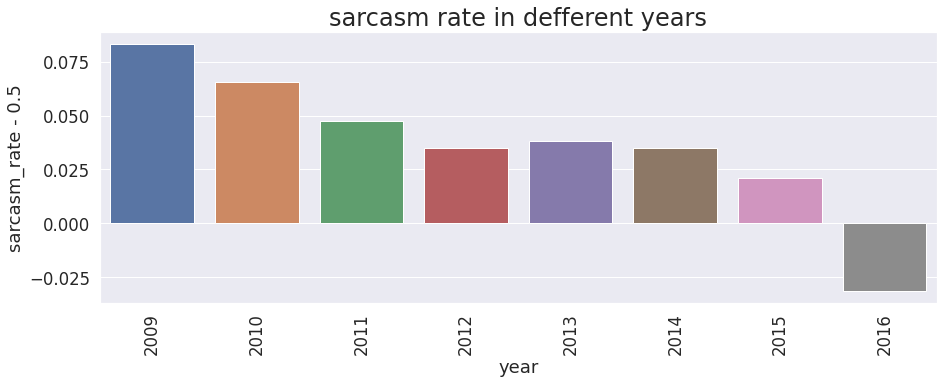

In [39]:
year_df = df.groupby('year')['label'].agg([np.size, np.mean, np.sum]).reset_index()
year_df['sarcasm_rate - 0.5'] = year_df['mean'] - 0.5

sns.set(font_scale=1.5)
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=year_df.sort_values(by='size', ascending=False) , x='year', y='sarcasm_rate - 0.5')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.set(font_scale=2)
ax.set_title("sarcasm rate in defferent years");

before 2011 people were considerably more sarcastic. 2016 seems to begin the trend of being less sarcastic. so we add these features too.

In [40]:
df['2016'] = df.year >= 2016
df['old_years'] = df.year <= 2011
df.drop("year", axis=1, inplace=True)

In [41]:
df.head()

,label,comment,subreddit,score,parent_comment,comment_len,midnight,afternoon,Weekend,Tuesday,end_of_year,beginning_of_year,2016,old_years
0,0,NC and NH.,0.105521,2,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well.",10,False,False,True,False,True,False,True,False
1,0,You do know west teams play against west teams more than east teams right?,0.026279,-4,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.,74,True,False,False,True,True,False,True,False
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",0.004146,3,They're favored to win.,121,False,False,False,False,False,False,True,False
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",-0.120219,-8,deadass don't kill my buzz,60,False,False,False,True,True,False,True,False
4,0,"I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)",-0.097693,0,do you find ariana grande sexy ?,112,False,False,False,False,False,False,True,False


finally, we scale the non-text features we have derived by now with a simple scaler that makes the mean 0 and the variance 1.

In [44]:
non_text_feats = ['subreddit', 'score', 'comment_len', 'midnight', 'afternoon', 'Weekend', 'Tuesday', 'end_of_year', 'beginning_of_year', '2016', 'old_years']
standard_scaler = StandardScaler()
df[non_text_feats] = standard_scaler.fit_transform(df[non_text_feats])

now that we're done with non-text features, let's get to **text features**. 

here is our preprocessing function. it doesn the following:
- make the text lower case
- expands contractions. e.g. `i'm -> i am`
- remove stop words. stop word dictionary is provided by gensim.
- remove punctuations and numbers
- lemmatize words. e.g. `walking -> walk` , `books -> book`
- tokenize the string.

the final result for each comment is a list of *very clean* words.

notice that the function gets three options, each of which determine if a special cleaning is done or not.

In [45]:
def apply_to_texts(df, func):
    df.comment = df.comment.apply(func)
    df.parent_comment = df.parent_comment.apply(func)

def preprocess(contract, stopword, lemm):
    idf = df.copy()
    apply_to_texts(idf, lambda cell: cell.lower())

    if contract:
        import contractions
        apply_to_texts(idf, contractions.fix)

    if stopword:
        from gensim.parsing.preprocessing import remove_stopwords
        apply_to_texts(idf, remove_stopwords)

    from gensim.utils import tokenize
    apply_to_texts(idf, tokenize)

    if lemm:
        from nltk.stem import WordNetLemmatizer
        wnl = WordNetLemmatizer()
        apply_to_texts(idf, lambda li: [wnl.lemmatize(i) for i in li])

    return idf

#***Models***

first we define several functions that will help us in training and testing models.

this function produces the final feature matrices(for both validation and train) ready to be given straight to a model. 

inputs:
- vectorizer: used to convert comment which is a list of words to a vector of features.
- cdf: data frame which contains all the non-text and text features.

procedure:
- split cdf into train and validation data frames.
- fit vectorizer on training set comments then transform comments of both training and validation set.
- stack the text vectors returned from vectorizer to the non-text features. 

output:
- return training feature matrix, validation feature matrix and also training and validation labels.

In [46]:
def get_the_4(vectorizer, cdf):
    train_df, valid_df = train_test_split(cdf, test_size=.2)
    train_text_feat = vectorizer.fit_transform(train_df.comment)
    valid_text_feat = vectorizer.transform(valid_df.comment)
    train_feat = hstack([train_text_feat, train_df[non_text_feats]])
    valid_feat = hstack([valid_text_feat, valid_df[non_text_feats]])
    return train_feat, valid_feat, train_df['label'], valid_df['label']

evaluates given model and prints evaluation metrics.

inputs:
- model to be evaluated
- feature rows to make predictions on
- actual labels to evaluate predictions

procedure:

evaluation metrics are calculated with the `classification_report` which prints all sort of metrics like precision, recall and f1 for both 0 and 1 labels.

In [47]:
def eval_model(model, feat, label):
    label_pred = model.predict(feat)
    print(classification_report(label, label_pred))

we wanted to test models on different types of preprocessing, so we defines the method below which get the needed matrices as input, trains a logistic regression model and evaluates it. this way we have less code which is also more elegant!

In [48]:
def lr_try(train_feat, valid_feat, train_label, valid_label):
    lr_model = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=2)
    lr_model.fit(train_feat, train_label)
    eval_model(lr_model, valid_feat, valid_label)
    return lr_model

the logistic regression below is trained with all the preprocessing options on. as we see the f1 score is 0.65

In [49]:
cdf = preprocess(True, True, True)
tfidf_vectorizer1 = TfidfVectorizer(max_features=1000, analyzer=lambda li: li)
df1, df2, df3, df4 = get_the_4(tfidf_vectorizer1, cdf)
lr_model1 = lr_try(df1, df2, df3, df4)
eli5.show_weights(lr_model1, feature_names=tfidf_vectorizer1.get_feature_names()+non_text_feats, target_names = [0,1])

              precision    recall  f1-score   support

           0       0.65      0.70      0.68     80796
           1       0.68      0.62      0.65     80996

    accuracy                           0.66    161792
   macro avg       0.66      0.66      0.66    161792
weighted avg       0.66      0.66      0.66    161792



Weight?,Feature
+4.182,obviously
+3.805,dropped
+3.790,totally
+3.642,forgot
+3.619,clearly
+3.467,duh
+3.426,shitlord
+3.419,dare
+3.077,yeah
+2.760,racist


below, we have disabled stop word removal. as we see, the f1 has increased to 0.67

In [50]:
cdf = preprocess(True, False, True)
tfidf_vectorizer2 = TfidfVectorizer(max_features=1000, analyzer=lambda li: li)
df1, df2, df3, df4 = get_the_4(tfidf_vectorizer2, cdf)
lr_model2 = lr_try(df1, df2, df3, df4)
eli5.show_weights(lr_model2, feature_names=tfidf_vectorizer2.get_feature_names()+non_text_feats, target_names = [0,1])

              precision    recall  f1-score   support

           0       0.67      0.71      0.69     80714
           1       0.70      0.65      0.67     81078

    accuracy                           0.68    161792
   macro avg       0.68      0.68      0.68    161792
weighted avg       0.68      0.68      0.68    161792



Weight?,Feature
+4.978,obviously
+4.796,dropped
+4.645,forgot
+4.562,totally
+4.464,clearly
+4.050,dare
+3.972,shitlord
+3.755,yeah
+3.578,duh
+3.530,because


maybe we're better off without any preprocessing. without expanding contraction or removing stop words or lemmatizing words we can also use n-gram features(n consecutive words are used as a feature). let's try it.

In [51]:
cdf = df
tfidf_vectorizer3 = TfidfVectorizer(max_features=1000, ngram_range=(1,3))
df1, df2, df3, df4 = get_the_4(tfidf_vectorizer3, cdf)
lr_model3 = lr_try(df1, df2, df3, df4)
eli5.show_weights(lr_model3, feature_names=tfidf_vectorizer3.get_feature_names()+non_text_feats, target_names = [0,1])

              precision    recall  f1-score   support

           0       0.67      0.72      0.69     80784
           1       0.70      0.65      0.67     81008

    accuracy                           0.68    161792
   macro avg       0.68      0.68      0.68    161792
weighted avg       0.68      0.68      0.68    161792



Weight?,Feature
+6.170,yes because
+5.089,obviously
+4.707,clearly
+4.637,you dropped
+4.474,how dare
+4.409,totally
+4.325,yeah because
+3.959,but but
+3.751,forgot the
+3.675,duh


the sad truth is that yeah, all those preprocessing were not helping at all. the logistic regression above is trained on the vectorized raw comments and has f1 score of 0.67. also notice that some n-grams are now very influential in recognizing sarcastic comments.

<hr/>

let's train the same model on the same dataframe, but with more features for vectorizer to see what is the best performance of logistic regression

In [66]:
cdf = df
tfidf_vectorizer4 = TfidfVectorizer(max_features=1000000, ngram_range=(1,3))
df1, df2, df3, df4 = get_the_4(tfidf_vectorizer4, cdf)
lr_model4 = lr_try(df1, df2, df3, df4)
eli5.show_weights(lr_model4, feature_names=tfidf_vectorizer4.get_feature_names()+non_text_feats,target_names = [0,1])

              precision    recall  f1-score   support

           0       0.73      0.75      0.74     80597
           1       0.74      0.72      0.73     81195

    accuracy                           0.73    161792
   macro avg       0.73      0.73      0.73    161792
weighted avg       0.73      0.73      0.73    161792



Weight?,Feature
+10.333,yes because
+9.606,clearly
+9.581,obviously
+9.241,totally
+9.205,because
+8.230,yeah because
+6.365,good thing
+5.888,how dare
+5.805,yeah
+5.689,fault


the resulting f1 score is 0.73 which is great.

<hr/>

next we wanted to try the svm model. we had a very hard time and never got good results. we tried different kernels, different number of input features and also increased max_iter as long as we had the patience to wait. the code below with 3000 iters took about 20 minutes, AND didn't turn out good results so we didn't have any more motivation to increase iterations any further and moved on to the next model. the results are worse than random, which makes us doubt if we have done something horribly wrong, but we couldn't find anything.

In [54]:
cdf = df
tfidf_vectorizer5 = TfidfVectorizer(max_features=100000, ngram_range=(1,3))
df1, df2, df3, df4 = get_the_4(tfidf_vectorizer5, cdf)
svm_model = SVC(max_iter=3000, kernel='linear', )
svm_model.fit(df1, df3)
eval_model(svm_model, df2, df4)
eli5.show_weights(svm_model, feature_names=tfidf_vectorizer5.get_feature_names()+non_text_feats,target_names = [0,1])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.76      0.10      0.18     80835
           1       0.52      0.97      0.68     80957

    accuracy                           0.54    161792
   macro avg       0.64      0.54      0.43    161792
weighted avg       0.64      0.54      0.43    161792



the next thing we tried was the AdaBoost classifier which we learned about in the course! first we used 100 estimators and got 0.67 f1 score which was not bad relative to the training time so we increased it to 1000 and waited an hour to get disappointed with 0.70 f1 score.

In [66]:
cdf = df
tfidf_vectorizer6 = TfidfVectorizer(max_features=100000, ngram_range=(1,3))
df1, df2, df3, df4 = get_the_4(tfidf_vectorizer6, cdf)
ab_model = AdaBoostClassifier(n_estimators=1000)
ab_model.fit(df1, df3)
eval_model(ab_model, df2, df4)

              precision    recall  f1-score   support

           0       0.69      0.76      0.72     80844
           1       0.73      0.67      0.70     80948

    accuracy                           0.71    161792
   macro avg       0.71      0.71      0.71    161792
weighted avg       0.71      0.71      0.71    161792



it's the first time we have non-word features show up in high influences. here we see `comment_len` and `score`.

In [69]:
eli5.show_weights(ab_model, feature_names=tfidf_vectorizer6.get_feature_names()+non_text_feats,target_names = [0,1])

Weight,Feature
0.0300 ± 0.3412,subreddit
0.0110 ± 0.2086,comment_len
0.0050 ± 0.1411,forgot
0.0050 ± 0.1411,score
0.0040 ± 0.1262,racist
0.0030 ± 0.1094,sure
0.0030 ± 0.1094,but
0.0030 ± 0.1094,dropped
0.0030 ± 0.1094,yes
0.0030 ± 0.1094,well


# RNN Model with Word2Vec Embedding
here we import our necessery modules:

In [94]:
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from gensim.models import Word2Vec
from keras.preprocessing import text, sequence
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow as tf

In this section we send the keras and tensorflow models to GPU

In [48]:
# config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
# sess = tf.compat.v1.Session(config=config) 
# keras.backend.set_session(sess)

First we want to train a Word2Vec model and we use both `comment` and `parent_comment` columns for training it so we will concat them and feed them to our model.

In [51]:
list_of_lists = pd.concat([df.comment, df.parent_comment]).to_numpy()

In [52]:
EMBEDDING_DIM = 200
# tex = list(df.parent_comment.apply(lambda c: list(tokenize(c, to_lower=True))))
# model = Word2Vec(sentences=tex, window=5, min_count=1, workers=4)
w2v_model = Word2Vec(sentences = list_of_lists , size=EMBEDDING_DIM , window = 5 , min_count = 1, workers=2)
len(w2v_model.wv.vocab)

226669

In this section we use a `toknizer` in order to make our data less memory intensive.

In [53]:
list_of_lists = df.comment.to_numpy()

In [54]:
tokenizer = text.Tokenizer(num_words=200000)
tokenizer.fit_on_texts(list_of_lists)
tokenized_train = tokenizer.texts_to_sequences(list_of_lists)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [55]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

129264

`get_weight_matirix` function gives Word2Vec model and tokenizer dict and returns a matrix with index of tokenizer vlues and value of Word2Vec values for each considered word and one row for not considered words.

In [56]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [57]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)
embedding_vectors.shape

(129264, 200)

Here we define our RNN wiht a `Bidirectional(LSTM)` and a `Bidirectional(GRU)` and then we delete the embedding_vectors in order to free memory.

In [58]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           25852800  
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 26,245,441
Trainable params: 26,245,441
Non-trainable params: 0
_________________________________________________________________


here we split train and validation data. here we use validation data only for flowing model's fiting processes and comparing it with train data results.

In [60]:
x_train, x_validation, y_train, y_validation = train_test_split(x, df.label , test_size = 0.3 , random_state = 0) 

In [61]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_validation, y_validation) , epochs = 3)

Epoch 1/3
4424/4424 [==============================] - 3600s 804ms/step - loss: 0.6089 - acc: 0.6625 - val_loss: 0.5939 - val_acc: 0.6775
Epoch 2/3
4424/4424 [==============================] - 3553s 803ms/step - loss: 0.5641 - acc: 0.7054 - val_loss: 0.6045 - val_acc: 0.6733
Epoch 3/3
4424/4424 [==============================] - 3534s 799ms/step - loss: 0.5519 - acc: 0.7129 - val_loss: 0.6179 - val_acc: 0.6718


As we can see we got prety normal result on train and validation sets and we expect to see same results as vlidation on test set too.

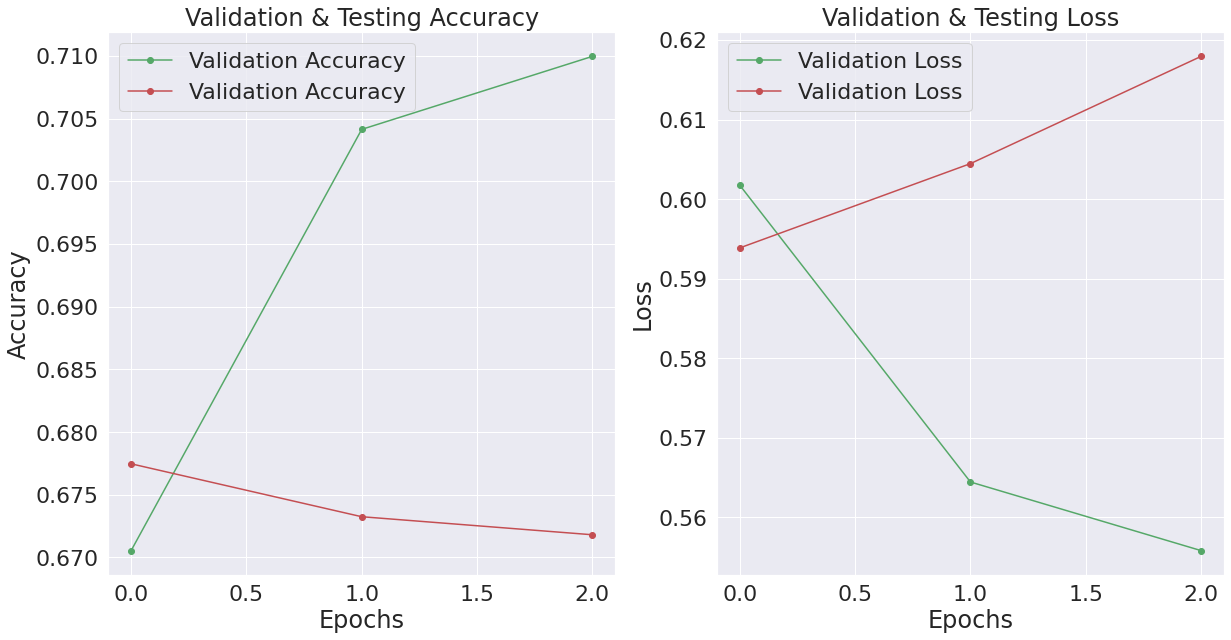

In [92]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Validation Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Validation & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Validation Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
ax[1].set_title('Validation & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

These plots show that we are overfited on train data just after first epoch and the rest of training was unnecessary.

<hr/>

Here we have modesl's confusion matirx for our validation data set.

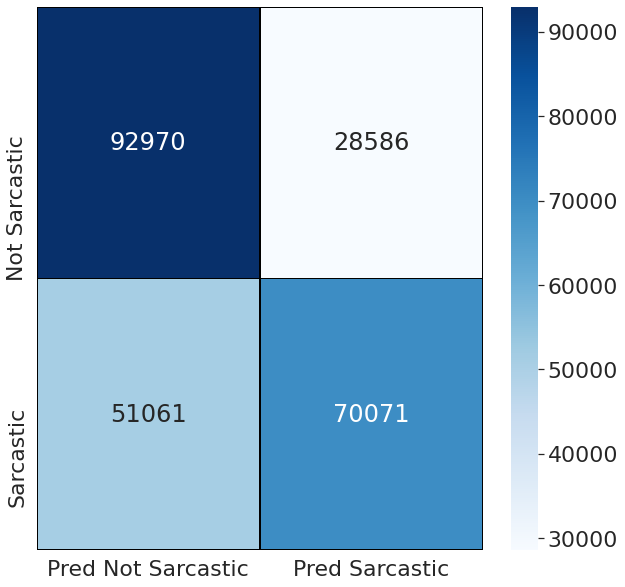

In [89]:
y_validation_pred = (model.predict(x_validation) > 0.5).astype("int32")
cm = confusion_matrix(y_validation, y_validation_pred)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Pred Not Sarcastic','Pred Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']);

This time we want to check our model F1 score (which is our main estimator for evaluation of models) on train set and validation set and compare our valdation set F1 score with other available models for selecting final model

In [97]:
y_train_pred = (model.predict(x_train) > 0.5).astype("int32")
print(f"F1 score of the model on Train Data: {f1_score(y_train, y_train_pred)}")
print(f"F1 score of the model on Validation Data: {f1_score(y_validation, y_validation_pred)}")

F1 score of the model on Train Data: 0.6982206747048046
F1 score of the model on Validation Data: 0.637620627055949


F1 score is lower than we expected for such a good model and such a long training time. but anyway we have tried so hard and got so far but in the end RNN doesn't even matter.

# ***Testing final model***

so all our models have been tested and f1 scores have been attained for them. the best f1 score was 0.73 for the `lr_model4` which is a logistic regression model trained with TF-IDF input. so this model relies heavily on the key words it has found to recognize sarcastic comments and doesn't actually understand anything. so if a comment is sarcastic but doesn't use one of the popular key words(n-grams) used to be sarcastic(!), `lr_model4` most probably won't recognizer that.

now let's test `lr_model4` on test dataset.

In [62]:
def get_cleand_df(df):
  df = df.copy(deep=True)

  df = df.drop(columns = ['Unnamed: 0', 'date'])
  
  df = df[df.comment.notna()]

  df['created_utc'] = pd.to_datetime(df['created_utc'], format="%Y-%m-%d")
  df['year'] = df['created_utc'].dt.year
  df['month'] = df['created_utc'].dt.month
  df['day_name'] = df['created_utc'].dt.day_name()
  df['day_time'] = pd.cut(df['created_utc'].dt.hour, bins=[0, 6, 12,18,24], labels=["midnight", "mornining", "afternoon", "night"], include_lowest=True, ordered=False)
  df = df.drop(columns=['created_utc'])

  df = df.drop(columns=['ups', 'downs'])

  df['comment_len'] = df.comment.str.len()

  df['subreddit'] = df.groupby('subreddit')['label'].transform('mean') - 0.5

  df.drop('author', axis=1, inplace=True);

  df['midnight'] = df.day_time == 'midnight'
  df['afternoon'] = df.day_time == 'afternoon'
  df.drop('day_time', axis=1, inplace=True)

  df['Weekend'] = (df.day_name == "Sunday") | (df.day_name == "Saturday")
  df['Tuesday'] = df.day_name == "Tuesday"
  df.drop('day_name', axis=1, inplace=True)

  df['end_of_year'] = df.month >= 10
  df['beginning_of_year'] = df.month <= 7
  df.drop('month', axis=1, inplace=True)

  df['2016'] = df.year >= 2016
  df['old_years'] = df.year <= 2011
  df.drop("year", axis=1, inplace=True)

  non_text_feats = ['subreddit', 'score', 'comment_len', 'midnight', 'afternoon', 'Weekend', 'Tuesday', 'end_of_year', 'beginning_of_year', '2016', 'old_years']
  standard_scaler = StandardScaler()
  df[non_text_feats] = standard_scaler.fit_transform(df[non_text_feats])
  
  return df

In [63]:
test_df = pd.read_csv('sarcasm_test_set.csv')
test_df = get_cleand_df(test_df)
test_df.head()

,label,comment,subreddit,score,parent_comment,comment_len,midnight,afternoon,Weekend,Tuesday,end_of_year,beginning_of_year,2016,old_years
0,0,I could use one of those tools.,0.211115,-0.017957,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT,-0.357944,-0.630975,1.493627,-0.571955,-0.422351,1.49503,-1.018833,1.061524,-0.141802
1,0,Damn I was hoping God was real,0.162275,0.151541,James Shields Will Not Exercise Opt-Out Clause,-0.371847,-0.630975,-0.669511,-0.571955,-0.422351,1.49503,-1.018833,1.061524,-0.141802
2,0,This would make me cry.,-0.757040,-0.123893,"""You are like the end piece of bread in a loaf, everyone touches you but no one wants you.""",-0.469168,-0.630975,-0.669511,-0.571955,-0.422351,1.49503,-1.018833,1.061524,-0.141802
3,0,At first I thought it was instructions on fixing a car.... It wasn't.,-0.269521,-0.123893,Found this under a box of porno mags well cleaning out a trailer...,0.170368,-0.630975,-0.669511,1.748390,-0.422351,1.49503,-1.018833,1.061524,-0.141802
4,0,My stuffed animal I've had since I was born.,-0.757040,-0.123893,"Your house is burning down and you only have time to grab one thing ( not including family or pets ), what do you grab?",-0.177206,-0.630975,-0.669511,-0.571955,2.367697,1.49503,-1.018833,1.061524,-0.141802


In [69]:
test_text_feat = tfidf_vectorizer4.transform(test_df.comment)
test_feat = hstack([test_text_feat, test_df[non_text_feats]])
eval_model(lr_model4, test_feat, test_df.label)

              precision    recall  f1-score   support

           0       0.73      0.76      0.74    101180
           1       0.75      0.72      0.73    100633

    accuracy                           0.74    201813
   macro avg       0.74      0.74      0.74    201813
weighted avg       0.74      0.74      0.74    201813



as we see, the f1 score of 0.73 is exactly what we expected.

# Sources
<a href="https://radimrehurek.com/gensim/models/word2vec.html#introduction">
Gensim Word2vec model
</a>
<br/>
<a href="https://stackoverflow.com/questions/22272370/word2vec-effect-of-window-size-used">
effect of window size on Word2vec
</a>
<br/>
<a href="https://towardsdatascience.com/5-simple-ways-to-tokenize-text-in-python-92c6804edfc4#dfd5">
Tokenize Text in Python
</a>
<br/>
<a href="https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908">
Text Preprocessing in Python
</a>
<br/>
<a href="https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution/notebook">
kaggle0
</a>
<br/>
<a href="https://www.kaggle.com/morkvas/lemmatization-stemming-and-stopwords/notebook">
kaggle1
</a>
<br/>
<a href="https://www.kaggle.com/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy">
kaggle2
</a>
<br/>
<a href="https://www.kaggle.com/yabutaka/learning-sarcasm-with-bidirectional-gru">
kaggle3
</a>
<br/>
<a href="https://www.kaggle.com/prashantkikani/are-you-being-sarcastic-sarcasm-detection-nlp">
kaggle4
</a>
<br/>
<a href="https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470">
RNN0
</a>
<br/>
<a href="https://towardsdatascience.com/guide-to-custom-recurrent-modeling-in-keras-29027e3f8465">
RNN1
</a>
<br/>
any many others...